In [1]:
from GetData import GetDataLoader,GetMnistData
from Model_package.MLP.MLP import MLP
from Model_package.FGSM.fgsm import get_fgsm_samples_data
from Model_package.FGSM import fgsm
import torch
import numpy as np
import os
import torch.nn.functional as F

import sys
from matplotlib import pyplot as plt

In [2]:
sys.path.append(r'F:\\神经网络的鲁棒性探究\\Adversarial_clearning')

In [3]:
sys.path

['F:\\神经网络的鲁棒性探究',
 'C:\\Users\\KING\\anaconda3\\python38.zip',
 'C:\\Users\\KING\\anaconda3\\DLLs',
 'C:\\Users\\KING\\anaconda3\\lib',
 'C:\\Users\\KING\\anaconda3',
 '',
 'C:\\Users\\KING\\anaconda3\\lib\\site-packages',
 'C:\\Users\\KING\\anaconda3\\lib\\site-packages\\locket-0.2.1-py3.8.egg',
 'C:\\Users\\KING\\anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\KING\\anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\KING\\anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\KING\\anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\KING\\.ipython',
 'F:\\\\神经网络的鲁棒性探究\\\\Adversarial_clearning']

In [4]:
layer_num = 4

In [5]:
def GetAvailablePath(filepath, layer_num):
    
    basename,extname=os.path.splitext(filepath)
    newPath=basename+"_layer"+str(layer_num)+extname
    
    
    #basename,extname=os.path.splitext(filepath)
    #count=0
    #newPath=basename+str(count)+extname
    #while os.path.exists(newPath):
    #   count+=1
    #    newPath=basename+str(count)+extname
    return newPath

def RecursiveCreatePath(filepath):
    dirname,basename=os.path.split(filepath)
    if not os.path.exists(dirname):
        RecursiveCreatePath(dirname)
    if not os.path.exists(filepath):
        os.mkdir(filepath)

In [6]:
attack_epsilon = 1

In [7]:
trainData,testData=GetMnistData()
testdataLoader=torch.utils.data.DataLoader(testData,batch_size=len(testData),shuffle=False)
traindataLoader=torch.utils.data.DataLoader(trainData,batch_size=len(trainData),shuffle=False)

In [8]:
filenames={}
filenames['MLPModelPath']="./Models/mlp_layer"+str(layer_num)+".pt"

In [9]:

filenames['rootDir']=GetAvailablePath("./AdversarialSamples", layer_num)

filenames['ClassifierMLPPath']="./Models/classifierMLP.pt"
filenames['TrainAdversarialPath']=GetAvailablePath(os.path.join(filenames['rootDir'],"adversarialDataTrian-25-model.npy"), layer_num)
filenames['TestAdversarialPath']=GetAvailablePath(os.path.join(filenames['rootDir'],"adversarialDataTest-25-model.npy"), layer_num)

RecursiveCreatePath(filenames['rootDir'])

In [10]:
#filenames['TrainDataPath']=os.path.join(filenames['rootDir'],"DataTrian-25-model.npy"))
#filenames['TestDataPath']=os.path.join(filenames['rootDir'],"DataTest-25-model.npy")
#filenames['TrainTargetsPath']=os.path.join(filenames['rootDir'],"TargetsTrian-25-model.npy")
#filenames['TestTargetsPath']=os.path.join(filenames['rootDir'],"targetsTest-25-model.npy")



filenames['TrainDataPath']=GetAvailablePath(os.path.join(filenames['rootDir'],"DataTrian-25-model.npy"), layer_num)
filenames['TestDataPath']=GetAvailablePath(os.path.join(filenames['rootDir'],"DataTest-25-model.npy"),layer_num)
filenames['TrainTargetsPath']=GetAvailablePath(os.path.join(filenames['rootDir'],"TargetsTrian-25-model.npy"),layer_num)
filenames['TestTargetsPath']=GetAvailablePath(os.path.join(filenames['rootDir'],"targetsTest-25-model.npy"), layer_num)


In [11]:
mlp = torch.load(filenames['MLPModelPath'])

In [12]:
mlp

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
  )
  (classification): Classifier(
    (layers): ModuleList(
      (0): Linear(in_features=100, out_features=10, bias=True)
    )
  )
)

In [13]:
train_final_acc, train_adv_data = fgsm.test(mlp,"cpu",traindataLoader, attack_epsilon)
test_final_acc, test_adv_data = fgsm.test(mlp,"cpu",testdataLoader, attack_epsilon)

Epsilon: 1	Test Accuracy = 1243 / 60000 = 2.071667%
Epsilon: 1	Test Accuracy = 172 / 10000 = 1.720000%


In [14]:
trainData.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [15]:
np.save(filenames['TrainAdversarialPath'],train_adv_data.cpu().detach().numpy())
np.save(filenames['TestAdversarialPath'],test_adv_data.cpu().detach().numpy())

In [16]:
np.save(filenames['TrainDataPath'],trainData.data.cpu().detach().numpy())
np.save(filenames['TestDataPath'],testData.data.cpu().detach().numpy())

In [17]:
np.save(filenames['TrainTargetsPath'],trainData.targets.cpu().detach().numpy())
np.save(filenames['TestTargetsPath'],testData.targets.cpu().detach().numpy())

<ipython-input-18-3514a93e670d>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


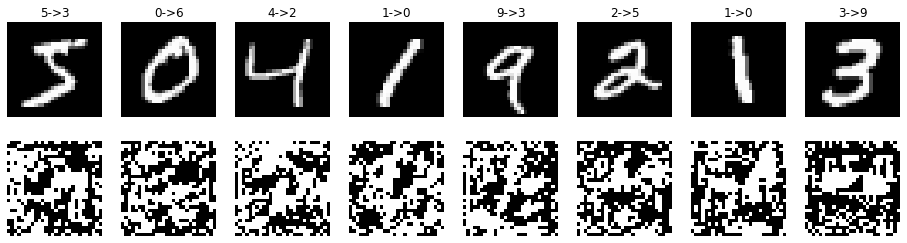

In [18]:
index=[0,1,2,3,4,5,6,7]
fig,ax=plt.subplots(2,len(index),figsize=(2*len(index),2*2))
adSample=train_adv_data[index]
orignSample=(trainData.data[index])
originLabel=trainData.targets[index]
adLabel=torch.argmax(mlp(adSample),dim=1).cpu().detach().numpy()
for i in range(len(index)):
    ax[0][i].imshow(orignSample[i],cmap="gray")
    ax[1][i].imshow(adSample[i].cpu().detach().numpy().squeeze(),cmap="gray")
    ax[0][i].axis("off")
    ax[1][i].axis("off")
    ax[0][i].set_title(str(originLabel[i].item())+"->"+str(adLabel[i]))
fig.show()

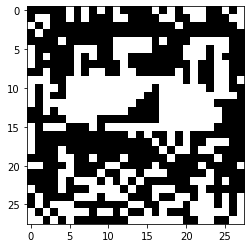

In [19]:
plt.imshow(train_adv_data[7].cpu().detach().numpy().squeeze(),cmap="gray")

In [20]:
for i in range(10000):
    if int(trainData.targets[i]) == int(torch.argmax(mlp(train_adv_data[i]),dim=1).cpu().detach().numpy()):
        print(i)

12
135
214
378
426
522
562
632
640
724
908
994
1245
1264
1301
1313
1322
1332
1345
1373
1395
1397
1417
1466
1629
1649
1692
1845
1911
1979
2000
2004
2007
2014
2027
2031
2069
2073
2133
2145
2147
2165
2229
2253
2279
2319
2354
2380
2401
2433
2489
2650
2743
2750
2867
2881
2891
2905
2917
3250
3531
3578
3599
3659
3705
3747
3798
3846
3894
4077
4191
4194
4234
4254
4472
4477
4480
4497
4513
4515
4519
4545
4549
4591
4618
4647
4683
4709
4719
4765
4841
4867
4888
4984
5027
5032
5182
5300
5312
5318
5332
5380
5385
5387
5407
5433
5461
5579
5639
5652
5995
6013
6025
6028
6053
6109
6119
6131
6167
6173
6201
6215
6253
6280
6283
6297
6299
6351
6386
6429
6507
6519
6527
6569
6650
6878
6882
6968
7001
7008
7038
7046
7085
7096
7120
7165
7236
7332
7334
7362
7382
7408
7418
7608
7841
7849
7878
7887
7892
7899
7915
7985
8002
8091
8245
8337
8342
8462
8516
8553
8561
8567
8573
8621
8627
8667
8808
8901
8946
8991
9023
9037
9111
9172
9231
9297
9303
9327
9343
9388
9416
9426
9502
9510
9515
9544
9553
9565
9589
9600
9649
9660
978

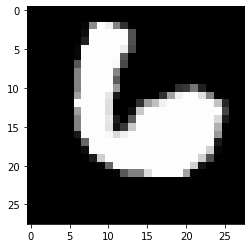

In [29]:
plt.imshow(train_adv_data[1466].cpu().detach().numpy().squeeze(),cmap="gray")

In [22]:
mlp0 = torch.load(filenames['MLPModelPath'])

In [23]:
output = mlp0(train_adv_data[91])

In [24]:
trainData.targets[91]

tensor(7)

In [25]:
torch.tensor([trainData.targets[91]])

tensor([7])

In [26]:
output

tensor([[ 58.2876, -52.8286, -34.0647, -46.3733, -58.6903,  -8.5539, -33.8582,
         -25.9546, -55.7735, -42.0082]], grad_fn=<AddmmBackward>)